<a href="https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/DeepLab_TFLite_CityScapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb. Thanks to [Khanh](https://twitter.com/khanhlvg) for helping out with the issues. The models used here were trained on the CityScapes dataset. 

## Setup

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


## Loading the model files

In [2]:
#@title Downloading and extracting the model checkpoints

MODEL_NAME = "xception65_cityscapes_trainfine" #@param ["mobilenetv3_large_cityscapes_trainfine", "xception65_cityscapes_trainfine"] 

DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
MODEL_URLS = {
    'mobilenetv3_large_cityscapes_trainfine':
        'deeplab_mnv3_large_cityscapes_trainfine_2019_11_15.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}

import os
MODEL_URL = DOWNLOAD_URL_PREFIX + MODEL_URLS[MODEL_NAME]
MODEL_FILE = MODEL_URL.split('/')[4]

!wget {MODEL_URL}

import tarfile
FROZEN_GRAPH_NAME = 'frozen_inference_graph'
tar_file = tarfile.open(MODEL_FILE)
for tar_info in tar_file.getmembers():
    if FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        print("Frozen graph found at: ",tar_info.name)
        file_handle = tar_file.extractfile(tar_info)

--2020-06-10 12:25:29--  http://download.tensorflow.org/models/deeplabv3_cityscapes_train_2018_02_06.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.111.128, 2607:f8b0:4001:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.111.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460310119 (439M) [application/x-tar]
Saving to: ‘deeplabv3_cityscapes_train_2018_02_06.tar.gz’

deeplabv3_cityscape 100%[===================>] 438.99M   123MB/s    in 3.6s    

2020-06-10 12:25:32 (123 MB/s) - ‘deeplabv3_cityscapes_train_2018_02_06.tar.gz’ saved [460310119/460310119]

Frozen graph found at:  deeplabv3_cityscapes_train/frozen_inference_graph.pb


## Creating SavedModel from of the frozen graph

In [3]:
# The preprocessing and the post-processing steps should not be included in the TF Lite model graph 
# because some operations (ArgMax) might not support the delegates. 
# Insepct the graph using Netron.
import tempfile

graph_def = tf.GraphDef()
graph_def.ParseFromString(file_handle.read())

with tf.Session(graph=tf.Graph()) as sess:
    tf.import_graph_def(graph_def, name="")
    
    g = tf.get_default_graph()

    # Need to remove the pre-processing and post-processing subgraph
    # https://github.com/tensorflow/models/blob/462459131a741f87c410b5fa51ec9df2c1b1c3ae/research/deeplab/export_model.py#L77
    input_tensor = g.get_tensor_by_name('sub_7:0') # For the other model it needs to be `sub_2:0`
    output_tensor = g.get_tensor_by_name('ResizeBilinear_2:0')

    saved_model_dir = tempfile.mkdtemp()

    tf.saved_model.simple_save(
        sess,
        saved_model_dir,
        inputs={input_tensor.name: input_tensor},
        outputs={output_tensor.name: output_tensor}
    )

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmp618pcsxh/saved_model.pb


In [4]:
!ls -lh {saved_model_dir}

total 159M
-rw-r--r-- 1 root root 159M Jun 10 12:25 saved_model.pb
drwxr-xr-x 2 root root 4.0K Jun 10 12:25 variables


## Switch to TensorFlow 2

***Restart your runtime before executing the below code snippets.***

In [1]:
%tensorflow_version 2.x
import tensorflow as tf 
print(tf.__version__)

2.2.0


In [2]:
converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/tmp618pcsxh/') # Change accordingly from the previous step
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
import tempfile

_, tflite_path = tempfile.mkstemp('.tflite')

with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

!ls -lh {tflite_path}

-rw------- 1 root root 40M Jun 10 12:27 /tmp/tmp1uiwb1kw.tflite


## Inference

In [4]:
# Load the model.
interpreter = tf.lite.Interpreter(model_path=tflite_path)

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# get image size - converting from BHWC to WH # ([1,1025,2049,19]: Shape of ResizeBilinear_2 op)
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]
print(input_size)

(2049, 1025)


In [5]:
#@title Provide a URL to your image to download
IMAGE_URL = 'https://miro.medium.com/max/1000/1*-gfo7jybQLx6qYAKeaOMrA.jpeg' #@param {type:"string"}
!wget {IMAGE_URL}

--2020-06-10 12:27:22--  https://miro.medium.com/max/1000/1*-gfo7jybQLx6qYAKeaOMrA.jpeg
Resolving miro.medium.com (miro.medium.com)... 104.16.118.145, 104.16.117.145, 104.16.119.145, ...
Connecting to miro.medium.com (miro.medium.com)|104.16.118.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88669 (87K) [image/jpeg]
Saving to: ‘1*-gfo7jybQLx6qYAKeaOMrA.jpeg’

1*-gfo7jybQLx6qYAKe 100%[===================>]  86.59K  --.-KB/s    in 0.01s   

2020-06-10 12:27:23 (6.91 MB/s) - ‘1*-gfo7jybQLx6qYAKeaOMrA.jpeg’ saved [88669/88669]



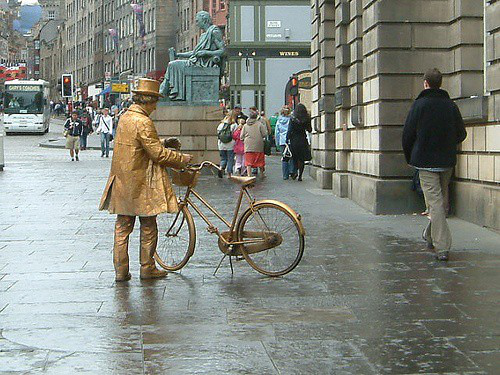

In [6]:
from PIL import Image

image = Image.open('1*-gfo7jybQLx6qYAKeaOMrA.jpeg') # Change this filename accordingly
image

In [0]:
# Preprocessing: convert the input image to the size required by the model
# Courtesy: Khanh
import numpy as np 

resized_image = image.convert('RGB').resize(input_size, Image.BILINEAR)
# Add a batch dimension and convert to a NumPy array
image_for_prediction = np.asarray(resized_image).astype(np.float32)
image_for_prediction = np.expand_dims(image_for_prediction, 0)
image_for_prediction = image_for_prediction / 255.0

# Load the model.
interpreter = tf.lite.Interpreter(model_path=tflite_path)

# Invoke the interpreter to run inference.
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], image_for_prediction)
interpreter.invoke()

# Retrieve the raw output map.
raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

# Post-processing: convert raw output to segmentation output
## Method 1: argmax before resize - this is used in some frozen graph
# seg_map = np.squeeze(np.argmax(raw_prediction, axis=3)).astype(np.int8)
# seg_map = np.asarray(Image.fromarray(seg_map).resize(image.size, resample=Image.NEAREST))
## Method 2: resize then argmax - this is used in some other frozen graph and produce smoother output
width, height = image.size
seg_map = tf.argmax(tf.image.resize(raw_prediction, (height, width)), axis=3)
seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)

The following code comes from [here](https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb). I took the colormap from [here](https://github.com/tensorflow/models/blob/master/research/deeplab/utils/get_dataset_colormap.py#L212). The label names come from [here](https://github.com/tensorflow/models/issues/6991#issue-454415742). 

In [0]:
#@title
from matplotlib import gridspec
from matplotlib import pyplot as plt

def create_cityscapes_label_colormap():
  """Creates a label colormap used in CITYSCAPES segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=np.uint8)
  colormap[0] = [128, 64, 128]
  colormap[1] = [244, 35, 232]
  colormap[2] = [70, 70, 70]
  colormap[3] = [102, 102, 156]
  colormap[4] = [190, 153, 153]
  colormap[5] = [153, 153, 153]
  colormap[6] = [250, 170, 30]
  colormap[7] = [220, 220, 0]
  colormap[8] = [107, 142, 35]
  colormap[9] = [152, 251, 152]
  colormap[10] = [70, 130, 180]
  colormap[11] = [220, 20, 60]
  colormap[12] = [255, 0, 0]
  colormap[13] = [0, 0, 142]
  colormap[14] = [0, 0, 70]
  colormap[15] = [0, 60, 100]
  colormap[16] = [0, 80, 100]
  colormap[17] = [0, 0, 230]
  colormap[18] = [119, 11, 32]
  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_cityscapes_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
      'road',
      'sidewalk',
      'building',
      'wall',
      'fence',
      'pole',
      'traffic light',
      'traffic sign',
      'vegetation',
      'terrain',
      'sky',
      'person',
      'rider',
      'car',
      'truck',
      'bus',
      'train',
      'motorcycle',
      'bicycle',
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

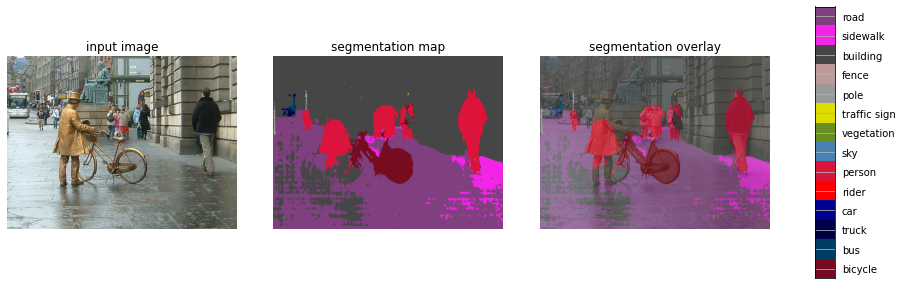

In [9]:
vis_segmentation(image, seg_map)

To try out a new model it's advisable to Factory Reset the runtime and then trying it.